In [120]:
import re
import cv2 
import numpy as np
import pytesseract
from pytesseract import Output
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display
import math
import matplotlib as mpl
import sumy
%matplotlib inline

## Supporting functions

In [121]:
# function to plot image.
def plotting(image, cmap = None):
    if cmap == 'gray':
        height, width = image.shape
    else:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        height, width, depth = image.shape
    
    dpi = mpl.rcParams['figure.dpi']
    figsize = width/float(dpi), height/float(dpi)
    fig = plt.figure(figsize = figsize)
    
    plt.imshow(image, cmap)

In [122]:
# Function to sort contours
import argparse
import imutils
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts)

## Main functions

In [123]:
# To extract image from the image:
# Work in progress
def getImage(documentPath):
    im = Image.open(documentPath)
    image = cv2.imread(documentPath)
    
    h, w, c = image.shape
    boxes = pytesseract.image_to_boxes(image)
    
    for b in boxes.splitlines():
        b = b.split(' ')
        image = cv2.rectangle(image, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 0, 0), 1)
        l = int(b[1])
        m =  h - int(b[2])
        n = int(b[3])
        o =  h - int(b[4])
        if n-l > 100:
            display(im.crop((l,o,n,m)))

In [138]:
# Pre-Processing image: Steps:
# 1. converting image to greyscale.
# 2. Otsu thresholding to make the image sharp again. 
# 3. Dilation to assist in finding contours
# 4. Finding and arranging contours in required format.
def identifyContours(documentPath, displayImage = False):
    image = cv2.imread(documentPath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (18, 18))
    dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1) 
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL,  
                                                     cv2.CHAIN_APPROX_NONE)
    cntos = sort_contours(contours)
    if displayContours:
        plotting(dilation, 'gray')
    return cntos

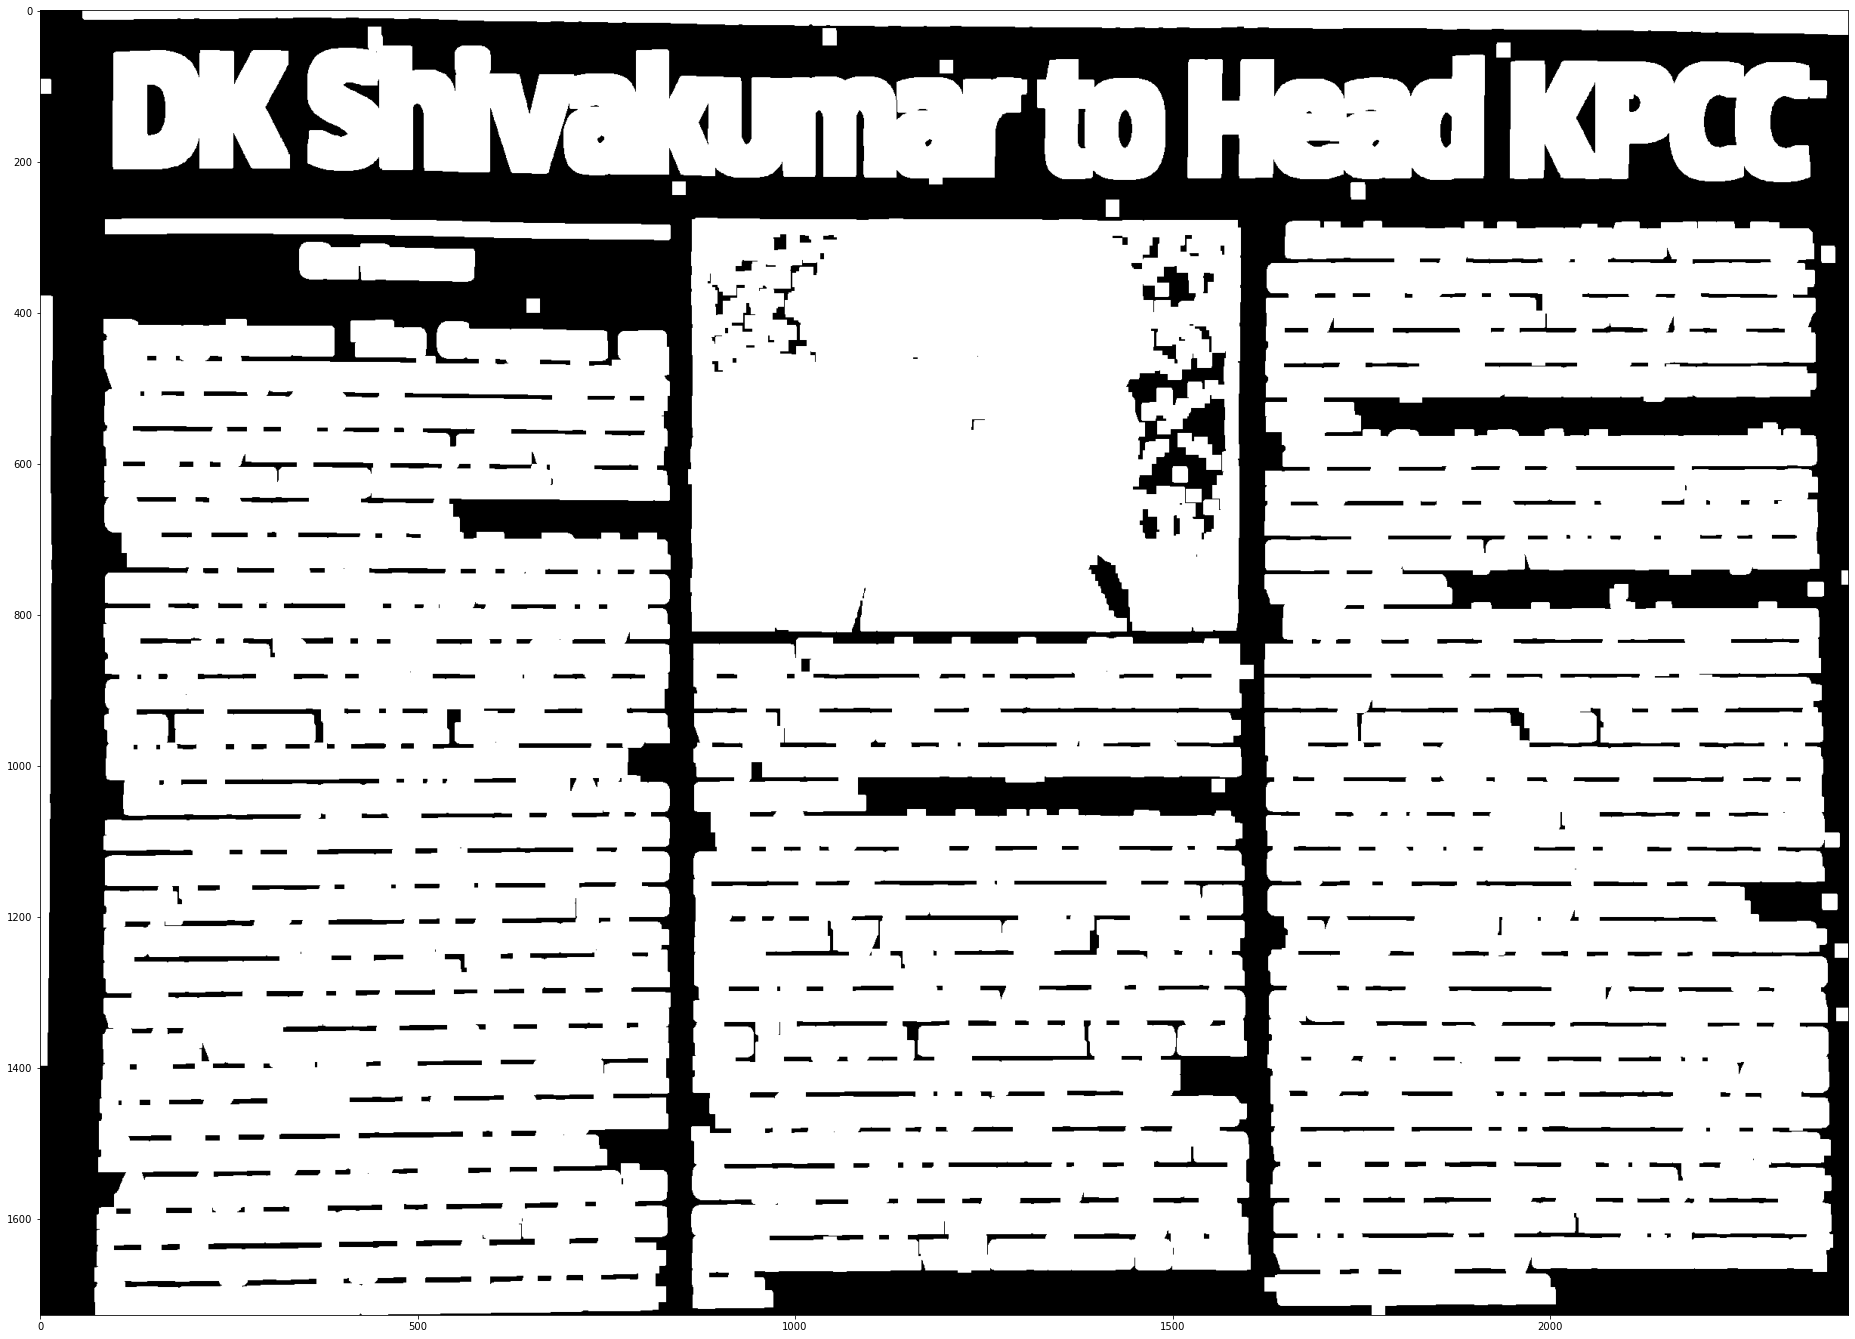

In [139]:
cntos = identifyContours('C:/Users/aksha/OneDrive/Desktop/Data Science Material/Capstone/Prashant/OCR_CAPSTONE/dks.jpg', True)

In [144]:
def extractText(documentPath, contours, printOutput = False):
    image = cv2.imread(documentPath)
    im2 = image.copy()
    finalString = ''
    
    im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
    im2 = cv2.bitwise_not(im2)
    
#     if '/' in documentPath:
#             fileName = documentPath.split('/')[-1].split('.')[0]
#         else if '\\' in documentPath:
#             fileName = documentPath.split('\\')[-1].split('.')[0]
#         else:
#             except('File Name Not Found.')
#         file = open(fileName+'.txt', "x")
        
        
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        rect = cv2.rectangle(im2, (x, y), (x + w, y + h), (0, 255, 0), 2) 
        cropped = im2[y:y + h, x:x + w]
        text = pytesseract.image_to_string(cropped)
        if len(text) > 20:
            finalString = finalString + text
        
    if printOutput:
        print(finalString)
    return finalString

Bengaluru: The Congress on
Wednesday announced senior leader DK
Shivakumar (57) as the new presidentof
the party in Karnataka, after weeks of
indecision since. incumbent Dinesh
Gundu Rao quitthe post.

The developments in Madhya Pradesh
seem to have led the party leadership to
make decision without further delay in
Karnataka. Denial of the state Congress
chief’s position in MP issaid to be one of
the reasons behind Jyotiraditya
Schindia’s decision to leave the party.

Shivakumar, an eight-time MLA who
now represents Kanakapura in the state
assembly, had beena front-runner for the
post, having established himself as the
go-to man for the party in times of elec-
tions or a political crisis. He is credited
withaseries of electoral.wins including
thatof VS Ugrappa from Ballariina Lok
Sabha byelection in November 2018, and
his brother DK Suresh from Bengaluru
Ruralin last year’s general election.

A post-graduate in political science, he
is involved with a number of activities
including run

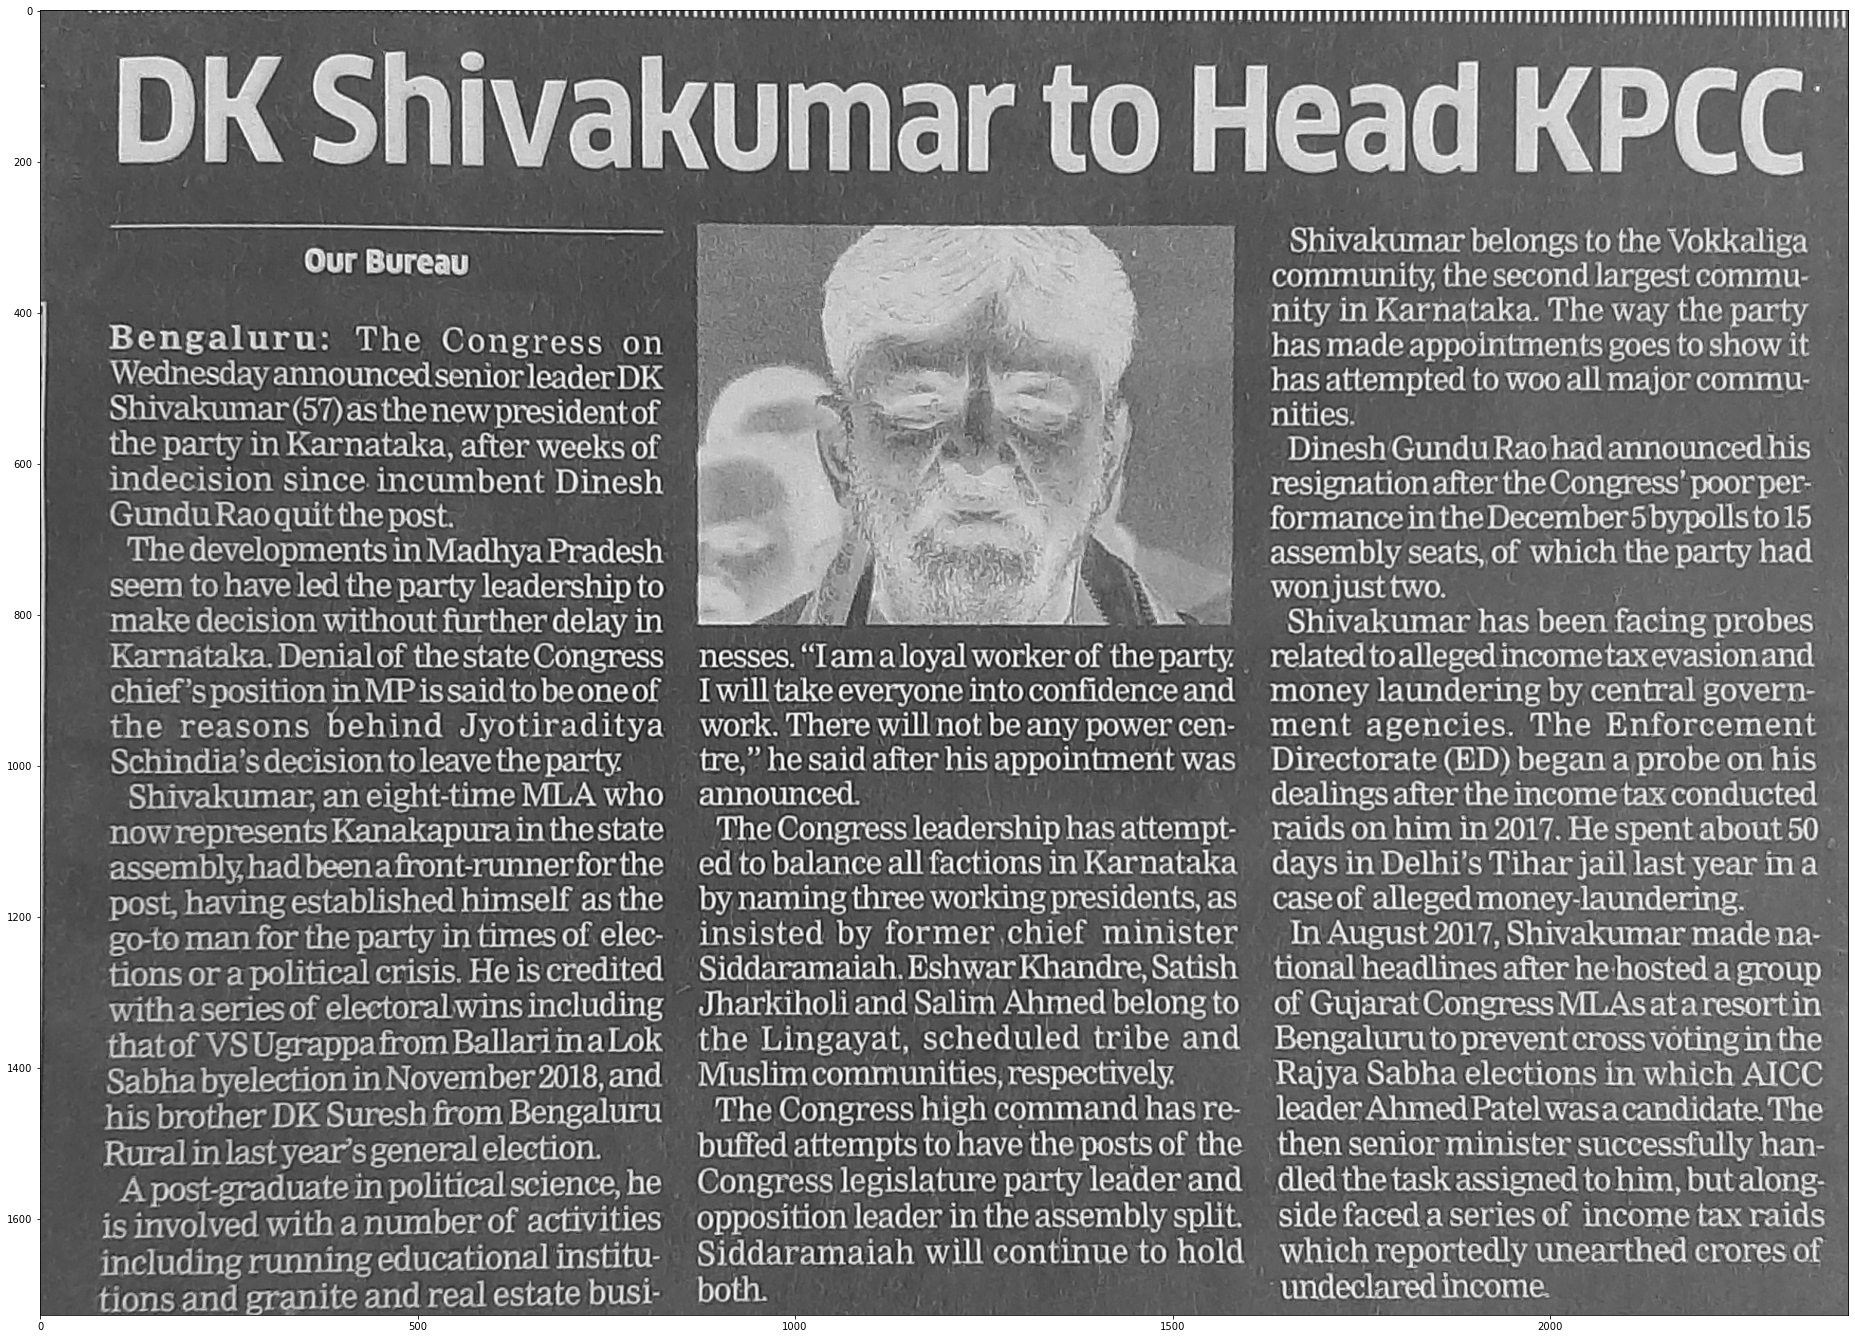

In [145]:
textExtract = extractText('C:\\Users\\aksha\\OneDrive\\Desktop\\Data Science Material\\Capstone\\Prashant\\OCR_CAPSTONE\\dks.jpg', cntos, True)

In [159]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer

def summarize(text, typeOfSummary, noOfSentences):
    finalSummary = ''
    text = text.replace('-\n', '')
    text = text.replace('\n', ' ')
    text = text.replace('  ', ' ')
    
    parser = PlaintextParser.from_string(text, Tokenizer('english'))
    
    if typeOfSummary == 'lexRank':
        from sumy.summarizers.lex_rank import LexRankSummarizer
        
        summarizer = LexRankSummarizer()
        summary = summarizer(parser.document, noOfSentences)
        
    elif typeOfSummary == 'luhn':
        from sumy.summarizers.luhn import LuhnSummarizer
        
        summarizer = LuhnSummarizer()
        summary =summarizer(parser.document,noOfSentences)
        
    elif typeOfSummary == 'lsa':
        from sumy.summarizers.lsa import LsaSummarizer
        
        summarizer = LsaSummarizer()
        summary = summarizer(parser.document, noOfSentences)
    
    if typeOfSummary in ['lexRank', 'luhn', 'lsa']:
        for i in summary:
            finalSummary = finalSummary + str(i) + '\n'
            
    return finalSummary

In [160]:
print(summarize(textExtract, 'lexRank', 10))

Bengaluru: The Congress on Wednesday announced senior leader DK Shivakumar (57) as the new presidentof the party in Karnataka, after weeks of indecision since.
incumbent Dinesh Gundu Rao quitthe post.
The developments in Madhya Pradesh seem to have led the party leadership to make decision without further delay in Karnataka.
Denial of the state Congress chief’s position in MP issaid to be one of the reasons behind Jyotiraditya Schindia’s decision to leave the party.
He is credited withaseries of electoral.wins including thatof VS Ugrappa from Ballariina Lok Sabha byelection in November 2018, and his brother DK Suresh from Bengaluru Ruralin last year’s general election.
“lamaloyal worker of the party.
_ I will take everyone into.confidence and work.
The Congress leadership has attempted to balance all factions in Karnataka by naming three working presidents, as insisted by former ,chief minister Siddaramaiah.
Dinesh'Gundu Rao had announced his resignation after the Congress’ poor perfor